# An√°lisis del modelo alom√©trico longitud-anchura

Para profundizar en el modelo alom√©trico definido por la expresi√≥n matem√°tica {eq}`eq_peso-longitud_anchura` es preciso adoptar una estrategia rigurosamente secuencial que combine diagn√≥stico estad√≠stico exhaustivo, exploraci√≥n de formas funcionales alternativas y validaci√≥n externa. A lo largo de este cap√≠tulo analizaremos cada uno de estas fases de forma pormenorizada.

## Prean√°lisis exploratorio (EDA)
El objetivo de esta fase inicial es detectar y, en su caso, justificar la exclusi√≥n o el trato robusto de valores at√≠picos en el dataset que puedan sesgar el c√°lculo de los par√°metros. Para ello se ha decidio no considerar en este an√°lisis los datos de `Superficie (cm2)` ya que son el resultado de la operaci√≥n $S=L \cdot A$ y no aporta informaci√≥n adicional, generando una colinealidad perfecta y por ello distornionando la detecci√≥n multivariante.

In [1]:
# CARGA Y VISTA R√ÅPIDA DE DATOS
# --------------------------------

# Cargar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (importado para scatter 3D)

sns.set(style="ticks", context="talk")    # estilo de gr√°ficas
plt.rcParams["figure.figsize"] = (8, 5)   # tama√±o base
plt.style.use('seaborn-v0_8-muted')

# Cargar el dataset
file_path = '.././data/Dimensiones_lenguado.xlsx'
df = pd.read_excel(file_path)

# Elimina/ignora cualquier columna que contenga 'superficie'
surface_cols = [c for c in df.columns if "superf" in c.lower()]
df = df.drop(columns=surface_cols, errors="ignore")  # errors="ignore" evita fallo si no existe

numeric_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)', 'Altura (cm)']

print("Forma:", df.shape)
display(df.head())
display(df.describe().transpose())


Forma: (209, 4)


Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)
0      0.46            3.3           1.3          0.2
1      1.08            4.5           1.1          0.3
2      0.67            3.9           1.5          0.2
3      0.98            4.4           1.7          0.3
4      0.93            4.2           1.8          0.3

count      mean       std   min   25%   50%   75%    max
Peso (g)       209.0  5.344641  3.635514  0.46  2.82  4.29  6.96  21.98
Longitud (cm)  209.0  7.244498  1.505369  3.30  6.10  7.00  8.30  11.40
Anchura (cm)   209.0  2.788995  0.698297  1.10  2.30  2.70  3.30   5.20
Altura (cm)    209.0  0.462679  0.117033  0.20  0.40  0.50  0.50   0.90

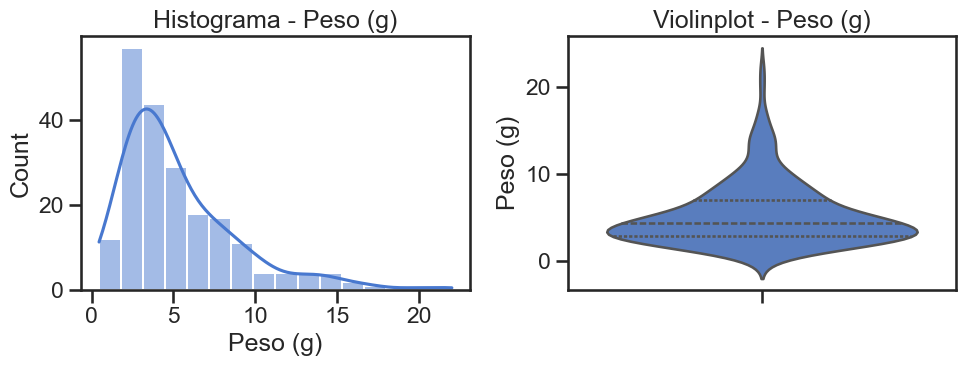

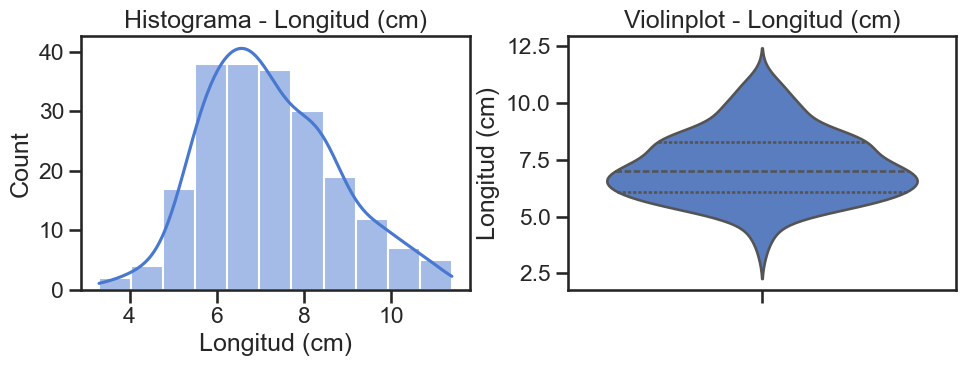

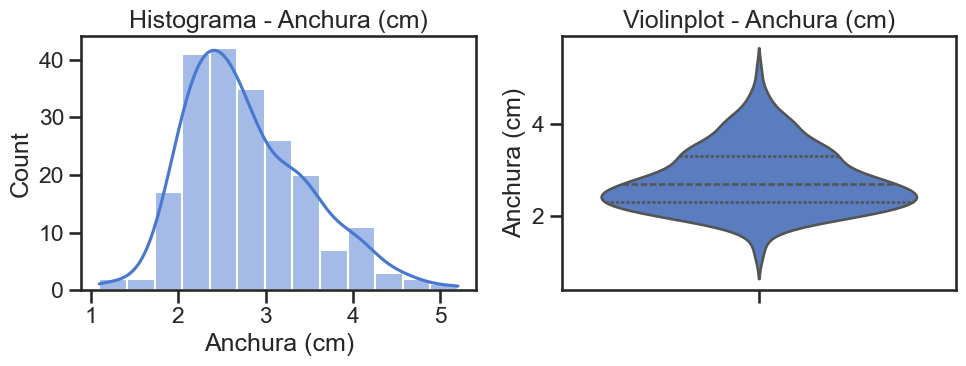

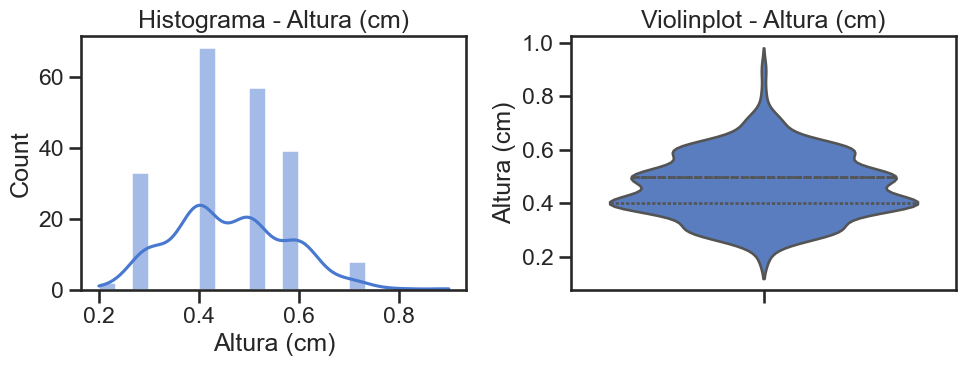

In [2]:
# DISTRIBUCIONES UNIVARIANTES
# ---------------------------

for col in numeric_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histograma - {col}")
    sns.violinplot(y=df[col], ax=ax[1], inner="quartile")
    ax[1].set_title(f"Violinplot - {col}")
    plt.tight_layout()

<table style="max-width:900px;width:100%;margin:auto;">
  <thead>
    <tr>
      <th style="background-color:#f2f2f2;font-weight:bold;border:1px solid #ccc;padding:6px;text-align:justify;">Variable</th>
      <th style="background-color:#f2f2f2;font-weight:bold;border:1px solid #ccc;padding:6px;text-align:justify;">Forma del viol√≠n</th>
      <th style="background-color:#f2f2f2;font-weight:bold;border:1px solid #ccc;padding:6px;text-align:justify;">Interpretaci√≥n</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Peso&nbsp;(g)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Ancho entre <strong>3¬†‚Äì¬†7¬†g</strong>, cola larga y estrecha hasta ‚âà‚ÄØ22¬†g, varios puntos fuera del bigote superior.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Distribuci√≥n <strong>fuertemente asim√©trica a la derecha</strong>: la mayor√≠a son ejemplares peque√±os‚Äëmedios y unos pocos muy pesados (outliers).</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Longitud&nbsp;(cm)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Viol√≠n casi sim√©trico, m√°s ancho en 6¬†‚Äì¬†8¬†cm, cola superior corta, sin puntos fuera del bigote.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Distribuci√≥n <strong>unimodal y estable</strong>; no hay valores extremos claros, buena candidata a predictor base.</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Anchura&nbsp;(cm)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Pico ancho en 2,5¬†‚Äì¬†3,5¬†cm, cola superior hasta 5,2¬†cm con muy poca densidad, 1‚Äë2 puntos aislados.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Forma similar a Longitud pero con <strong>cola alta leve</strong>; unos pocos peces muy anchos podr√≠an ser anomal√≠as o errores.</td>
    </tr>
    <tr>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;"><strong>Altura&nbsp;(cm)</strong></td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Viol√≠n estrecho (0,4¬†‚Äì¬†0,5¬†cm habituales), cola fina hasta 0,9¬†cm, varios puntos aislados arriba.</td>
      <td style="border:1px solid #ccc;padding:6px;text-align:justify;background-color:#ffffff;">Variable con <strong>rango peque√±o</strong>; valores altos destacan como outliers y podr√≠an indicar errores de medici√≥n o casos excepcionales.</td>
    </tr>
  </tbody>
</table>

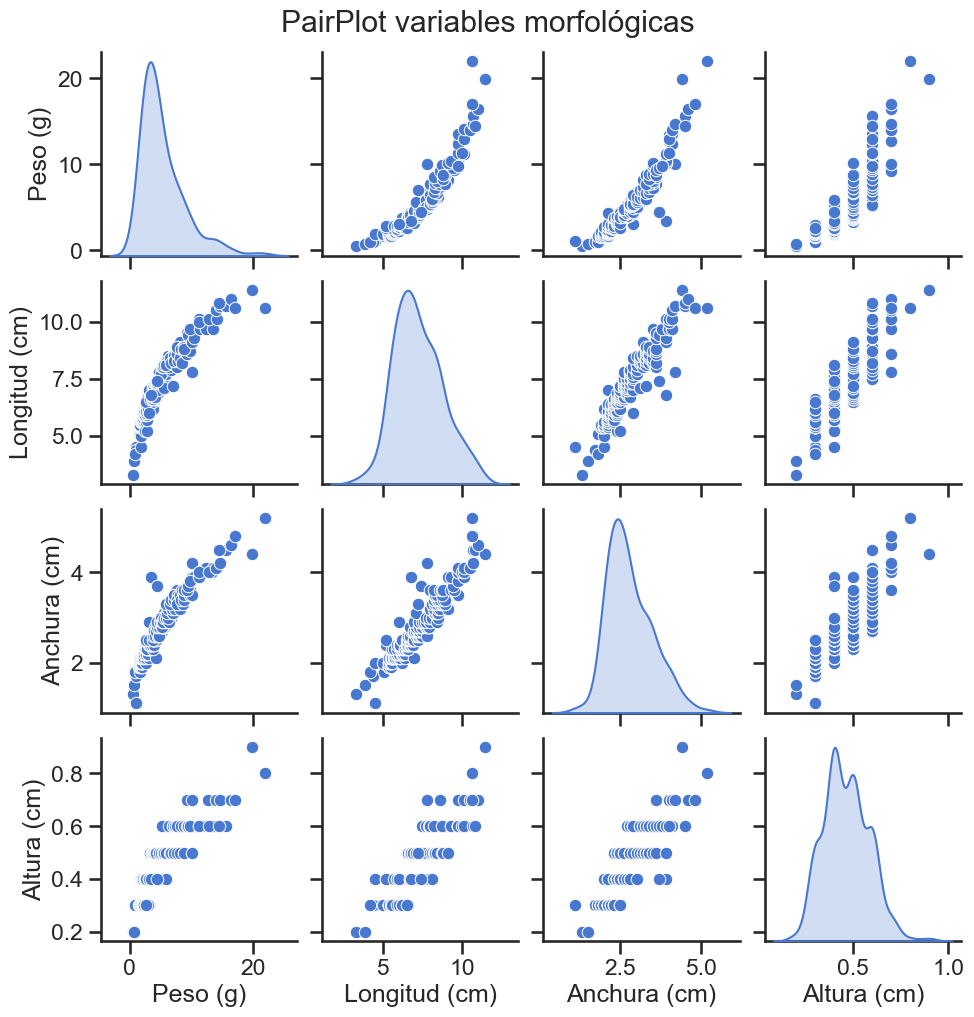

In [3]:
# MATRIZ DE DISPERSI√ìN
# --------------------
sns.pairplot(df[numeric_cols], diag_kind="kde")
plt.suptitle("PairPlot variables morfol√≥gicas", y=1.02);

La matriz de dispersi√≥n revela un patr√≥n claro de alometr√≠a: Peso crece exponencialmente con la Longitud y la Anchura, dibujando nubes curvil√≠neas donde los puntos se vuelven m√°s dispersos a medida que el pez gana tama√±o; eso confirma que la relaci√≥n no es estrictamente lineal en escala original y justifica la transformaci√≥n logar√≠tmica aplicada en el modelo $W=kL^{a}A^{b}$. Longitud y Anchura mantienen entre s√≠ una correlaci√≥n positiva moderada los peces m√°s largos tienden a ser m√°s anchos mientras que Altura se agrupa fuertemente en torno a un intervalo estrecho y, salvo algunos valores altos an√≥malos, aporta poca variabilidad adicional. En todas las combinaciones que incluyen Peso se aprecian varios puntos solitarios por encima de la nube principal, lo que corrobora la presencia de outliers pesados detectados num√©ricamente. No se observan clusters separados que sugieran sub-poblaciones distintas, sino una gradaci√≥n continua, de modo que los valores extremos se interpretan mejor como individuos excepcionales (o posibles errores) que como grupos diferenciados. **En conjunto, la dispersi√≥n respalda el uso de Longitud y Anchura como predictores principales, advierte sobre la influencia de los pesos extremos y confirma que la Altura puede excluirse sin p√©rdida sustancial de informaci√≥n.**

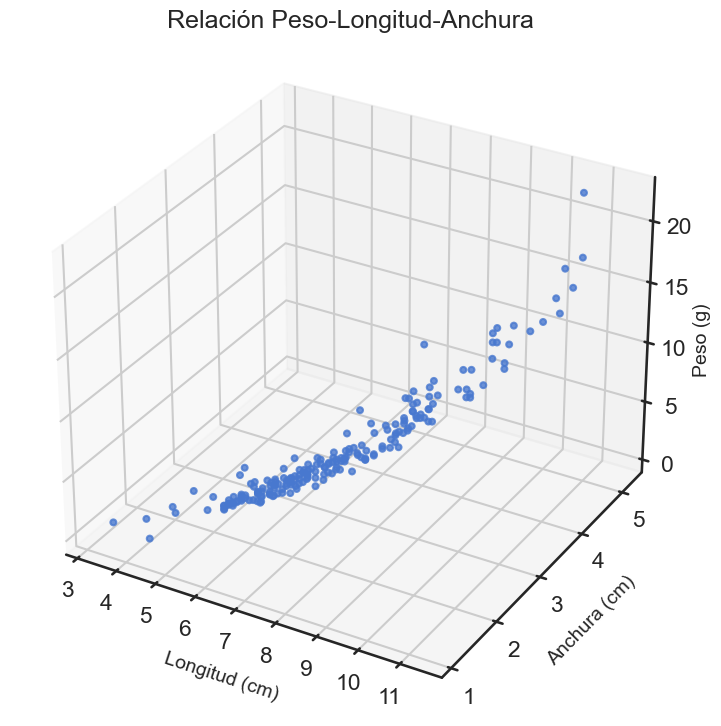

In [4]:
# SCATTER 3D PESO‚ÄìLONGITUD‚ÄìANCHURA
# --------------------------------
fig = plt.figure(figsize=(8,8)) 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Longitud (cm)'],
           df['Anchura (cm)'],
           df['Peso (g)'],
           s=18, alpha=0.8)

ax.set_xlabel('Longitud (cm)', labelpad=10, fontsize=14)
ax.set_ylabel('Anchura (cm)', labelpad=10, fontsize=14)
ax.set_zlabel('') # vaciamos el z-label ‚Äúnormal‚Äù

# Colocamos el texto como overlay 2-D para que no se recorte
fig.text(0.94, 0.52, 'Peso (g)', rotation=90,
         va='center', ha='center', fontsize=14)

ax.set_title("Relaci√≥n Peso-Longitud-Anchura")
ax.set_box_aspect([1, 1, 0.8])  
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.90)
plt.show()


El diagrama de dispersi√≥n tridimensional obtenido muestra que los datos se distribuyen sobre una superficie t√≠pica de crecimiento alom√©trico: el peso ($W$) aumenta de forma supralineal con la longitud ($L$) y la anchura ($A$). Esta curvatura descarta cualquier ajuste plano cl√°sico y avala la f√≥rmula {eq}`eq_peso-longitud_anchura`; en coordenadas logar√≠tmicas la nube se comprimir√≠a pr√°cticamente en un plano, lo que simplifica la estimaci√≥n de $a$, $b$ y $k$ mediante regresi√≥n lineal m√∫ltiple sobre $\ln W$.

La secci√≥n horizontal del gr√°fico exhibe una correlaci√≥n positiva marcada entre $L$ y $A$; sin embargo, la dispersi√≥n transversal confirma que la anchura aporta informaci√≥n independiente ‚Äî es decir, $b$ no resulta redundante respecto a $a$. Adem√°s, la amplitud de la nube crece con el tama√±o, evidenciando heterocedasticidad: los ejemplares grandes presentan mayor variabilidad relativa de peso. Este patr√≥n exige, o bien la transformaci√≥n log‚Äìlog previa al ajuste, o bien el empleo de estimadores ponderados o robustos para preservar la validez inferencial.

En la proyecci√≥n vertical se identifican varios individuos que se separan netamente de la masa principal: unos pocos muy pesados para su talla y uno o dos sorprendentemente livianos. Estos casos coinciden con los at√≠picos y deben revisarse individualmente ‚Äîpudiendo tratarse de errores de registro, diferencias de condici√≥n corporal o etapas ontog√©nicas poco representadas.

**En conclusi√≥n, el an√°lisis gr√°fico corrobora la idoneidad de un modelo alom√©trico en $L$ y $A$, subraya la necesidad de transformar logar√≠tmicamente los datos o emplear m√©todos robustos y pone de relieve la importancia de manejar adecuadamente los valores at√≠picos para obtener estimaciones fiables de los par√°metros biol√≥gicos.**

## Visualizaci√≥n de *outliers*

En el an√°lisis exploratorio se ha comprobado la existencia de *outliers* y su visualizaci√≥n es fundamental para comprender su impacto en la construcci√≥n del modelo predictivo. Estos valores at√≠picos pueden surgir por errores en la medici√≥n, variabilidad natural en la poblaci√≥n o condiciones excepcionales, y su presencia puede distorsionar los par√°metros estad√≠sticos y sesgar el modelo de regresi√≥n. Al representar gr√°ficamente los *outliers* se facilita la identificaci√≥n de observaciones aberrantes que podr√≠an afectar la linealidad, homocedasticidad o normalidad de los residuos. Adem√°s, su visualizaci√≥n permite evaluar si deben ser tratados mediante estrategias como winsorizaci√≥n, eliminaci√≥n o imputaci√≥n robusta, optimizando as√≠ la generalizaci√≥n del modelo.

Para contabilizar y visualizar estos *outliers* vamos a emplear primeramente un enfoque univariado (detecci√≥n en una dimensi√≥n) para despu√©s aplicar un enfoque multivariado que permite la detecci√≥n en m√∫ltiples variables.

### M√©todos univariados (detecci√≥n en una dimensi√≥n)

- **Rango intercuart√≠lico (IQR)** se define como la amplitud $Q_{3}-Q_{1}$, donde $Q_{1}$ y $Q_{3}$ son, respectivamente, los percentiles 25% y 75% de la distribuci√≥n ordenada de una variable aleatoria continua. Constituye una medida robusta de dispersi√≥n, insensible a colas pesadas o valores aberrantes, pues encapsula el 50% central de las observaciones. En procedimientos de depuraci√≥n de datos, el criterio aplicable considera at√≠pica toda observaci√≥n $x$ que verifique $x < Q_{1}-k\cdot \text{IQR}$ o $x > Q_{3}+k\cdot \text{IQR}$, con $k=1.5$ como valor convencional. Este umbral utiliza el IQR como escala de variabilidad intr√≠nseca y permite identificar *outliers* sin asumir normalidad ni recurrir a momentos de orden superior, favoreciendo diagn√≥sticos estad√≠sticos robustos en muestras heterog√©neas.
- **El Z-score**, o puntuaci√≥n est√°ndar, es una m√©trica estad√≠stica que cuantifica cu√°ntas desviaciones est√°ndar se aleja una observaci√≥n del valor medio de la distribuci√≥n, expresado como $Z=\dfrac{X‚àíŒº}{œÉ}$, donde $X$ es el valor observado, $Œº$ la media poblacional y $œÉ$ la desviaci√≥n est√°ndar. Este m√©todo es particularmente √∫til para identificar *outliers* en distribuciones normales o aproximadamente normales, consider√°ndose valores at√≠picos aquellos con $‚à£Z‚à£>3$ (umbral que abarca el 99.7% de los datos bajo la curva gaussiana). Sin embargo, su eficacia disminuye en distribuciones sesgadas o con colas pesadas, ya que la media y la desviaci√≥n est√°ndar son sensibles a valores extremos.


In [5]:
# -------------------------------------------------
#    METODOS UNIVARIADOS
# -------------------------------------------------
def iqr_mask(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (series < q1 - k*iqr) | (series > q3 + k*iqr)

# ********************************
#    IQR sobre cada variable
# ********************************
mask_iqr = (
    iqr_mask(df['Peso (g)']) |
    iqr_mask(df['Longitud (cm)']) |
    iqr_mask(df['Anchura (cm)'])
)

# Generamos una copia del data frame original
df_outliers = df.copy()

# A√±adimos los outliers detectados
df_outliers['out_IQR'] = mask_iqr


# Filtrar outliers y a√±adir columnas de diagn√≥stico
outliers_iqr = df_outliers[mask_iqr].copy()
outliers_iqr['Raz√≥n_outlier'] = ""

# Identificar qu√© variables contribuyeron

if 'Longitud (cm)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Longitud (cm)'])[mask_iqr], 'Raz√≥n_outlier'] += "Longitud; "
if 'Anchura (cm)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Anchura (cm)'])[mask_iqr], 'Raz√≥n_outlier'] += "Anchura; "
if 'Peso (g)' in df.columns:
    outliers_iqr.loc[iqr_mask(df['Peso (g)'])[mask_iqr], 'Raz√≥n_outlier'] += "Peso; "

# Mostrar resultado
print(f"IQR: N√∫mero de outliers detectados IQR: {len(outliers_iqr)}\n")
outliers_iqr.head(len(outliers_iqr))

IQR: N√∫mero de outliers detectados IQR: 11



Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)  out_IQR  \
194     13.45            9.7           4.0          0.6     True   
197     13.56            9.7           4.1          0.6     True   
200     14.13           10.1           4.1          0.7     True   
201     14.04           10.5           4.1          0.7     True   
202     14.67           10.7           4.2          0.7     True   
203     15.65           10.7           4.5          0.6     True   
204     14.50           10.8           4.5          0.6     True   
205     19.88           11.4           4.4          0.9     True   
206     16.47           11.0           4.6          0.7     True   
207     17.04           10.6           4.8          0.7     True   
208     21.98           10.6           5.2          0.8     True   

       Raz√≥n_outlier  
194           Peso;   
197           Peso;   
200           Peso;   
201           Peso;   
202           Peso;   
203           Peso;   
204           Peso;   
205           Peso;   
206           Peso;   
207           Peso;   
208  Anchura; Peso;

In [6]:
# ********************************
#    Z-SCORE sobre cada variable
# ********************************

from scipy.stats import zscore

def zscore_mask(series, threshold=3):
    z_scores = zscore(series)
    return abs(z_scores) > threshold

mask_zscore = (
    zscore_mask(df['Peso (g)']) |
    zscore_mask(df['Longitud (cm)']) |
    zscore_mask(df['Anchura (cm)'])
)
# Introducimos los outliers en el dataframe correspondiente
df_outliers["out_ZScore"] = mask_zscore

# Filtrar outliers y a√±adir columnas de diagn√≥stico
outliers_zscore = df_outliers[mask_zscore].copy()
outliers_zscore['Raz√≥n_outlier'] = ""

# A√±adir Z-scores para cada variable
for col in ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']:
    if col in df.columns:
        outliers_zscore[f'Z_{col}'] = zscore(df[col])[mask_zscore]

# Identificar qu√© variables contribuyeron
if 'Longitud (cm)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Longitud (cm)'])[mask_zscore], 'Raz√≥n_outlier'] += "Longitud; "
if 'Anchura (cm)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Anchura (cm)'])[mask_zscore], 'Raz√≥n_outlier'] += "Anchura; "
if 'Peso (g)' in df.columns:
    outliers_zscore.loc[zscore_mask(df['Peso (g)'])[mask_zscore], 'Raz√≥n_outlier'] += "Peso; "

# Mostrar resultado
print(f"Z-Score: N√∫mero de outliers detectados (|Z| > 3): {len(outliers_zscore)}\n")
display(outliers_zscore.style.format({f'Z_{col}': "{:.2f}" for col in ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)'] if col in df.columns}))

Z-Score: N√∫mero de outliers detectados (|Z| > 3): 4



### M√©todos multivariados

**Isolation Forest** es un algoritmo de detecci√≥n de anomal√≠as no supervisado basado en el principio de particiones aleatorias. A partir de un conjunto de $n$ observaciones $\{\mathbf{x}{i}\}{i=1}^{n}\subset\mathbb{R}^{p}$, se construye un bosque de $t$ √°rboles binarios denominados *iTrees*; cada *iTree* se genera seleccionando recursivamente, de forma aleatoria, (i) una caracter√≠stica $j\in\{1,\dots,p\}$ y (ii) un valor de corte $\theta$ comprendido entre los valores m√≠nimo y m√°ximo de la caracter√≠stica en el subconjunto actual. El proceso contin√∫a hasta que la partici√≥n contiene un √∫nico punto o alcanza una profundidad m√°xima $h_{\max}$. La idea fundamental es que las observaciones an√≥malas, al hallarse escasamente representadas y en regiones perif√©ricas del espacio de caracter√≠sticas, tienden a quedar aisladas tras un n√∫mero bajo de divisiones. Para cada muestra $\mathbf{x}$ se define una profundidad promedio $E[h(\mathbf{x})]$ ‚Äîpromediada sobre los $t$ √°rboles‚Äî y de ella se deduce la puntuaci√≥n de anomal√≠a

```{math}
:label: eq_iforest_1
s(\mathbf{x}) = 2^{-\frac{E[h(\mathbf{x})]}{c(n)}},
\qquad
c(n) = H_{n-1}-\frac{2(n-1)}{n},
```

donde $H_{n}$ es el $n$-√©simo n√∫mero arm√≥nico. Los valores de $s(\mathbf{x})$ se normalizan en $[0,1]$; puntuaciones pr√≥ximas a 1 indican observaciones susceptibles de ser outliers. El esquema evita suposiciones param√©tricas sobre la forma de la distribuci√≥n, es eficiente en alta dimensionalidad $(O(t\,n\log n))$ y permite fijar *a priori* la proporci√≥n esperada de anomal√≠as mediante el par√°metro `contamination`, lo que lo hace id√≥neo para depuraci√≥n robusta de conjuntos de datos complejos. 

Para abordar este algoritmo eliminamos de nuestro *dataset* la variable `Altura` porque como ya concluimos anteriormente su exclusi√≥n no produce p√©rmida fundamental de informaci√≥n y s√≠ podria afectar a los resultados. Previamente a la aplicacion del algoritmo es necesario normalizar (estandarizar) las columnas seleccionadas para garantizar la efectividad del algoritmo en la detecci√≥n de anomal√≠as. Al estandarizar las variables mediante la transformaci√≥n $\dfrac{X‚àíŒº}{œÉ}$, se homogenizan las escalas de todas las caracter√≠sticas, evitando que aquellas con magnitudes mayores dominen artificialmente el c√°lculo de anomal√≠as. Este paso es esencial porque *Isolation Forest*, al basarse en particiones aleatorias del espacio de caracter√≠sticas, puede generar sesgos en conjuntos de datos con variables en escalas heterog√©neas. La estandarizaci√≥n no solo mejora la sensibilidad del modelo a patrones multivariados de *outliers*, sino que tambi√©n facilita la interpretaci√≥n de los *scores* de anomal√≠a al operar en un espacio m√©trico coherente. Adicionalmente, al fijar la media en 0 y la varianza en 1, se optimiza el rendimiento computacional del algoritmo, ya que las distancias utilizadas en las particiones aleatorias de los √°rboles reflejan contribuciones equilibradas de todas las variables.

N¬∫ de outliers detectados: 36


Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)
0        0.46            3.3           1.3          0.2
1        1.08            4.5           1.1          0.3
2        0.67            3.9           1.5          0.2
3        0.98            4.4           1.7          0.3
4        0.93            4.2           1.8          0.3
5        1.89            4.5           2.0          0.4
6        1.60            5.1           1.8          0.3
92       3.06            6.0           2.9          0.4
141      6.96            7.2           3.3          0.5
153      3.40            6.8           3.9          0.4
156      4.50            7.4           3.7          0.4
183     10.08            7.8           4.2          0.7
185      9.79            9.7           3.5          0.6
186     10.10            9.7           3.5          0.6
187      9.28            9.5           3.6          0.6
188      9.51            9.4           3.7          0.6
189     10.18            9.1           3.9          0.5
190     10.38            9.3           3.9          0.6
191      9.82            9.7           3.8          0.6
192     11.35            9.7           4.0          0.6
193     12.70            9.7           4.0          0.7
194     13.45            9.7           4.0          0.6
195     11.22           10.1           3.9          0.6
196     12.37            9.7           4.1          0.6
197     13.56            9.7           4.1          0.6
198     11.28           10.0           4.0          0.6
199     12.91           10.1           4.0          0.6
200     14.13           10.1           4.1          0.7
201     14.04           10.5           4.1          0.7
202     14.67           10.7           4.2          0.7
203     15.65           10.7           4.5          0.6
204     14.50           10.8           4.5          0.6
205     19.88           11.4           4.4          0.9
206     16.47           11.0           4.6          0.7
207     17.04           10.6           4.8          0.7
208     21.98           10.6           5.2          0.8

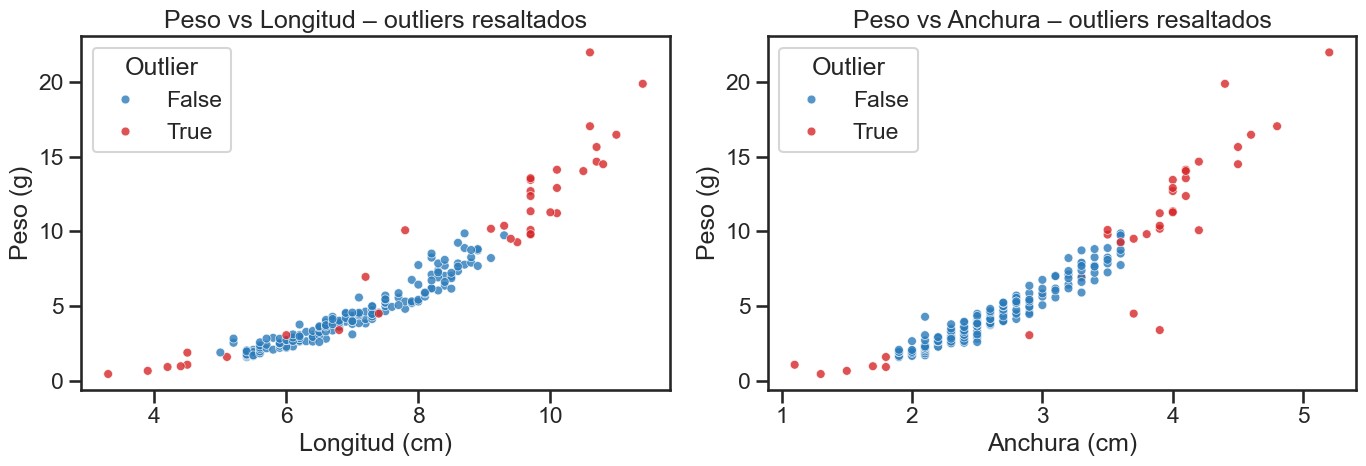

In [7]:
# ********************************
#  ISOLATION FOREST MULTIVARIABLE
# ********************************

iso = IsolationForest(contamination='auto', random_state=42)

# Eliminamos la columna altura del dataset
iso_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']
X = df[iso_cols]

# Normalizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

labels_iso = iso.fit_predict(X_scaled)
mask_iso = labels_iso == -1

# Guardamos los ouliers en el dataframe
df_outliers["out_iso"] = mask_iso

print(f"N¬∫ de outliers detectados: {df_outliers['out_iso'].sum()}")
display(df[df_outliers["out_iso"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gr√°fica 1
sns.scatterplot(data=df_outliers, x='Longitud (cm)', y='Peso (g)',
                hue='out_iso', ax=ax1,
                palette={False: "#2b7bba", True: "#d62728"},
                alpha=0.8, s=40)
ax1.set_title("Peso vs Longitud ‚Äì outliers resaltados")
ax1.legend(title="Outlier", loc="upper left")

# Gr√°fica 2
sns.scatterplot(data=df_outliers, x='Anchura (cm)', y='Peso (g)',
                hue='out_iso', ax=ax2,
                palette={False: "#2b7bba", True: "#d62728"},
                alpha=0.8, s=40)
ax2.set_title("Peso vs Anchura ‚Äì outliers resaltados")
ax2.legend(title="Outlier", loc="upper left")

plt.tight_layout()
plt.show()

Los tres m√©todos empelados para encontrar outliers presentan diferentes n√∫meros de *outliers*. Dado que cada algoritmo de detecci√≥n de *outliers* se fundamenta en marcos estad√≠sticos divergentes ‚Äîel m√©todo del rango intercuart√≠lico (IQR) opera bajo un enfoque univariante robusto basado en cuantiles, pero carece de sensibilidad para capturar relaciones multivariadas; el Z-score presupone una distribuci√≥n cuasi-normal y cuantifica desviaciones en unidades de escala est√°ndar; mientras que Isolation Forest implementa un paradigma no param√©trico que aisla observaciones at√≠picas en espacios p-dimensionales mediante hiperplanos aleatorios‚Äî, se deriva como consecuencia te√≥rica que los conjuntos de anomal√≠as identificados presentar√°n necesariamente solapamientos parciales.

Un an√°lisis de conjuntos (operaciones de intersecci√≥n y diferencia) puede ser una metodolog√≠a adecuada para: a) discriminar entre outliers de alta consistencia (aquellos que simult√°neamente exceden los umbrales de dispersi√≥n no param√©trica, violan los supuestos de normalidad y manifiestan rareza en la topolog√≠a multivariante), y b) identificar observaciones cuya clasificaci√≥n como at√≠picas es artefactual, dependiente de los supuestos espec√≠ficos de cada modelo. Este protocolo de validaci√≥n cruzada minimiza los errores de Tipo I (falsos positivos), incrementa la validez del preprocesamiento estad√≠stico y permite as√≠ una cuantificaci√≥n formal del sesgo metodol√≥gico inherente a cada t√©cnica.

El objetivo de este an√°lisis de conjuntos es delimitar aquellas observaciones que son identificadas como *outliers* por al menos dos m√©todos independientes, estableciendo as√≠ un criterio de consenso que refuerza la fiabilidad de la detecci√≥n. Cuando un mismo dato es marcado como an√≥malo por m√∫ltiples t√©cnicas ‚Äîcada una basada en supuestos estad√≠sticos distintos (p. ej., dispersi√≥n robusta, normalidad, o rareza multivariante)‚Äî, la probabilidad de que se trate de un verdadero valor aberrante, y no de un artefacto metodol√≥gico, aumenta significativamente.

Por tanto, estos *outliers* multimodales deben considerarse como observaciones genuinamente an√≥malas, ya sea debido a errores de medici√≥n o comportamientos sist√©micos at√≠picos, y su exclusi√≥n o tratamiento se justifica para garantizar la validez inferencial de los an√°lisis posteriores.


In [8]:
# Conjuntos y solapamientos
set_iqr = set(df_outliers.index[df_outliers['out_IQR']])
set_zscore   = set(df_outliers.index[df_outliers['out_ZScore']])
set_if  = set(df_outliers.index[df_outliers['out_iso']])

print("‚îÄ Outliers por m√©todo ‚îÄ\n")
print(f"IQR                : {len(set_iqr)}")
print(f"Z-Score |z| > 3    : {len(set_zscore)}")
print(f"Isolation Forest   : {len(set_if)}\n")

idx_common = np.array([
    sorted(set_iqr & set_zscore),
    sorted(set_iqr & set_if),
    sorted(set_zscore & set_if),
    sorted(set_iqr & set_zscore & set_if)
    ], dtype=object) # dtype=object para listas de distinto tama√±o

print("‚îÄ Intersecciones ‚îÄ\n")
print(f"IQR ‚à© Z-Score: {len(set_iqr & set_zscore)}")
outliers_common = df_outliers.loc[idx_common[0]] 
display(outliers_common)

print(f"IQR ‚à© Isolation Forest     : {len(set_iqr & set_if)}")
display(df_outliers.loc[idx_common[1]])

print(f"Z-Score ‚à© Isolation Forest : {len(set_zscore & set_if)}")
display(df_outliers.loc[idx_common[2]])

print(f"IQR ‚à© Z-Score ‚à© IF         : {len(set_iqr & set_zscore & set_if)}")
display(df_outliers.loc[idx_common[3]])

‚îÄ Outliers por m√©todo ‚îÄ

IQR                : 11
Z-Score |z| > 3    : 4
Isolation Forest   : 36

‚îÄ Intersecciones ‚îÄ

IQR ‚à© Z-Score: 4


Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)  out_IQR  out_ZScore  \
205     19.88           11.4           4.4          0.9     True        True   
206     16.47           11.0           4.6          0.7     True        True   
207     17.04           10.6           4.8          0.7     True        True   
208     21.98           10.6           5.2          0.8     True        True   

     out_iso  
205     True  
206     True  
207     True  
208     True

IQR ‚à© Isolation Forest     : 11


Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)  out_IQR  out_ZScore  \
194     13.45            9.7           4.0          0.6     True       False   
197     13.56            9.7           4.1          0.6     True       False   
200     14.13           10.1           4.1          0.7     True       False   
201     14.04           10.5           4.1          0.7     True       False   
202     14.67           10.7           4.2          0.7     True       False   
203     15.65           10.7           4.5          0.6     True       False   
204     14.50           10.8           4.5          0.6     True       False   
205     19.88           11.4           4.4          0.9     True        True   
206     16.47           11.0           4.6          0.7     True        True   
207     17.04           10.6           4.8          0.7     True        True   
208     21.98           10.6           5.2          0.8     True        True   

     out_iso  
194     True  
197     True  
200     True  
201     True  
202     True  
203     True  
204     True  
205     True  
206     True  
207     True  
208     True

Z-Score ‚à© Isolation Forest : 4


Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)  out_IQR  out_ZScore  \
205     19.88           11.4           4.4          0.9     True        True   
206     16.47           11.0           4.6          0.7     True        True   
207     17.04           10.6           4.8          0.7     True        True   
208     21.98           10.6           5.2          0.8     True        True   

     out_iso  
205     True  
206     True  
207     True  
208     True

IQR ‚à© Z-Score ‚à© IF         : 4


Peso (g)  Longitud (cm)  Anchura (cm)  Altura (cm)  out_IQR  out_ZScore  \
205     19.88           11.4           4.4          0.9     True        True   
206     16.47           11.0           4.6          0.7     True        True   
207     17.04           10.6           4.8          0.7     True        True   
208     21.98           10.6           5.2          0.8     True        True   

     out_iso  
205     True  
206     True  
207     True  
208     True

Los tres m√©todos usados coinciden en se√±alar los cuatros registros 205 - 208 como *outliers* lo cual es indicativo de posibles errores o individuos excepcionales en nuestro dataset y deber√≠an no ser considerados en una mejora del modelo alom√©trico inferido. Por otro lado los registros 194-204 detectados como valores an√≥malos por los m√©todos IRQ e Isolation Forest pueden representar sesgo de muestreo, diferencias de condici√≥n o simple variabilidad natural.

La relaci√≥n emp√≠rica $ùëä=ùëò \cdot L^a \cdot A^b$ es, por naturaleza, multiplicativa; de ella se deriva que la varianza de $ùëä$ crece proporcionalmente a $ùêø$ y $A$. Este comportamiento genera heterocedasticidad: los residuos asociados a los ejemplares grandes presentan una dispersi√≥n mucho mayor que los de los de menor trama√±o, Bajo esta condici√≥n, las m√©tricas univariantes (IQR, desviaciones ùëß) y los algoritmos multivariantes (Isolation Forest) operan con escalas que ‚Äúinflan‚Äù artificialmente la distancia de los ejemplares grandes y ‚Äúcomprimen‚Äù la de los peque√±os, sesgando la detecci√≥n de valores at√≠picos. Aplicar una **transformaci√≥n logar√≠tmica** $ln(‚ãÖ)$
convierte esa relaci√≥n de potencia en un modelo lineal aditivo y estabiliza la varianza, de modo que la dispersi√≥n residual es aproximadamente homoced√°stica y m√°s sim√©trica. Los trabajos de [Packart (2013)](https://doi.org/10.1111/bij.12038) y posteriormente de  [West (2022)](https://doi.org/10.1177/00045632211050531) han demostrado que, tras la aplicac√≥n de una transformada logar√≠tmica, las colas asim√©tricas se reducen y las pruebas basadas en desviaci√≥n est√°ndar recuperan su tasa nominal de error I, recomendando expl√≠citamente esta pr√°ctica previa a cualquier inferencia param√©trica.

En estudios ictiol√≥gicos recientes la pr√°ctica se ha consolidado como est√°ndar. [Rodr√≠guez-Garc√≠a et al. (2023)](https://doi.org/10.3390/fishes8050222) aplican la transformaci√≥n logar√≠tmica antes de filtrar anomal√≠as en m√°s de 40 especies descartadas por la flota del golfo de C√°diz y resaltan que, tras el log, s√≥lo persiste un subconjunto m√≠nimo de registros verdaderamente aberrantes, mientras que la mayor√≠a de los *outliers* iniciales se explican por la escala multiplicativa del crecimiento. [Xia et al. (2022)](https://doi.org/10.1016/j.ejar.2022.07.005) en seis especies del Yangts√©‚Äî siguen este protocolo: estiman los par√°metros en escala log y eval√∫an la calidad de ajuste y los residuos sobre los datos transformados, obteniendo un filtrado de anomal√≠as significativamente m√°s fiable.

````{admonition} Conclusi√≥n
:class: tip
En nuestro caso, transformar a $ln$ permitir√° redefinir los umbrales de IQR y Z-score sobre distribuciones casi sim√©tricas y comparables, validar la relevancia biol√≥gica de los registros 205‚Äì208 ‚Äîahora *outliers* un√°nimes‚Äî y re-evaluar los casos 194‚Äì204 en un entorno de varianza estabilizada, evitando expulsar datos v√°lidos que s√≥lo parec√≠an extremos por efecto de escala.
````

## Transformada logar√≠tmica

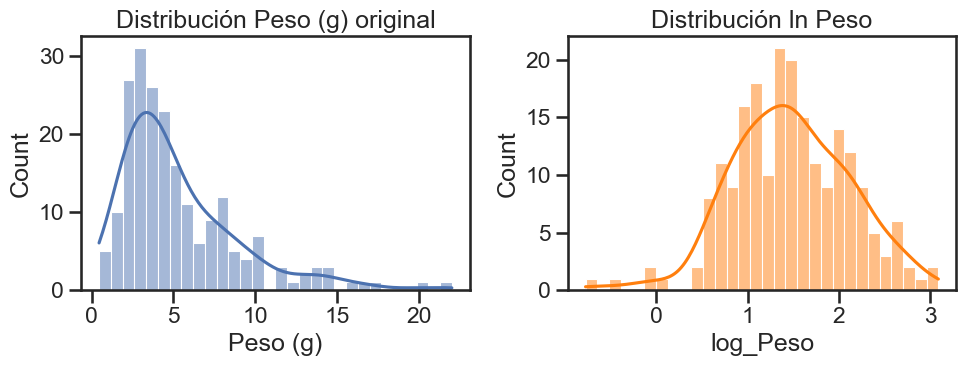

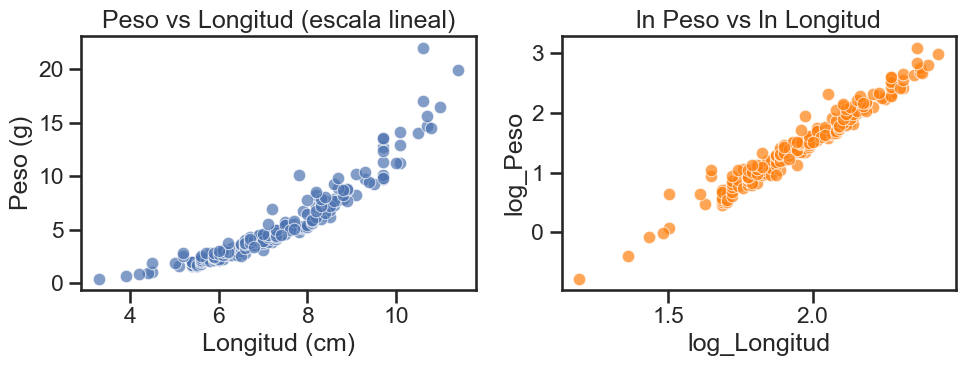

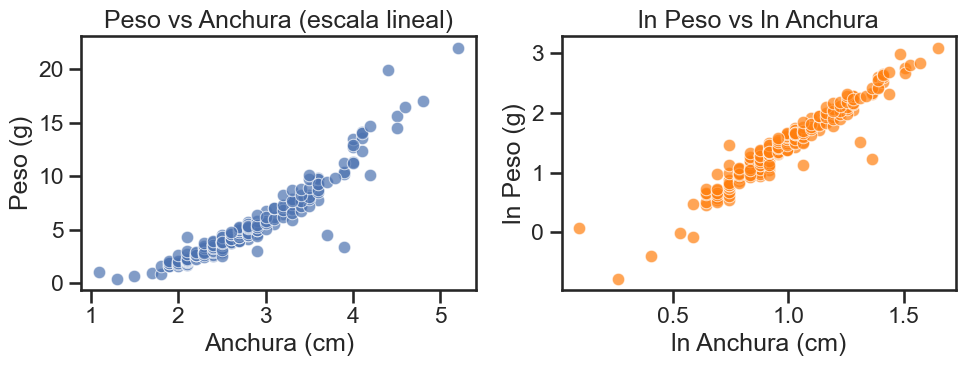

In [9]:
# ===============================================================
#     Transformaci√≥n logar√≠tmica, visualizaci√≥n preliminar
#          y re-detecci√≥n de outliers
# ===============================================================

# ---------------------------------------------------------------
# 1.  Seleccionar y depurar variables num√©ricas
# ---------------------------------------------------------------
numeric_cols = ['Peso (g)', 'Longitud (cm)', 'Anchura (cm)']

#eps = 1e-6                                 # evita log(0)
#df[numeric_cols] = df[numeric_cols].clip(lower=eps)

# ---------------------------------------------------------------
# 2.  Transformaci√≥n log-natural
# ---------------------------------------------------------------
df_log = df[numeric_cols].copy()
df_log = df_log[df_log['Peso (g)'] > 0]

df_log['log_Peso'] = np.log(df_log['Peso (g)'])
df_log['log_Longitud'] = np.log(df_log['Longitud (cm)'])
df_log['log_Anchura'] = np.log(df_log['Anchura (cm)'])

# ---------------------------------------------------------------
# 3.  Visualizar efecto de la transformaci√≥n
# ---------------------------------------------------------------
sns.set(style="ticks", context="talk")

## 3-a. Histogramas Peso: original vs ln
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df['Peso (g)'], ax=ax[0], bins=30, kde=True)
ax[0].set_title("Distribuci√≥n Peso (g) original")
sns.histplot(df_log['log_Peso'], ax=ax[1], bins=30, kde=True, color="#ff7f0e")
ax[1].set_title("Distribuci√≥n ln Peso")
plt.tight_layout()
plt.show()

## 3-b. Scatter Peso‚ÄìLongitud: lineal vs log-log
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=df, x='Longitud (cm)', y='Peso (g)', ax=ax[0], alpha=0.7)
ax[0].set_title("Peso vs Longitud (escala lineal)")
sns.scatterplot(x=df_log['log_Longitud'], y=df_log['log_Peso'], ax=ax[1], alpha=0.7, color="#ff7f0e")
ax[1].set_title("ln Peso vs ln Longitud")
plt.tight_layout()
plt.show()


## 3-c. Scatter Peso‚ÄìAnchura: lineal vs log-log
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(data=df,
                x='Anchura (cm)', y='Peso (g)',
                alpha=0.7, ax=ax[0])
ax[0].set_title("Peso vs Anchura (escala lineal)")
ax[0].set_xlabel("Anchura (cm)")
ax[0].set_ylabel("Peso (g)")
sns.scatterplot(x=df_log['log_Anchura'],
                y=df_log['log_Peso'],
                alpha=0.7, color="#ff7f0e", ax=ax[1])
ax[1].set_title("ln Peso vs ln Anchura")
ax[1].set_xlabel("ln Anchura (cm)")
ax[1].set_ylabel("ln Peso (g)")

plt.tight_layout()
plt.show()



Como se puede apreciar en las gr√°ficas obtenidas, el uso de la transformada logar√≠tmica produce una normalizaci√≥n de la distribuci√≥n sesgada del peso y una linealizaci√≥n de las relaciones exponenciales de Peso vs. Longitud y Peso vs. Anchura. En el primer caso, normalizaci√≠√≥n, esto nos va a permitir un mejor ajuste a modelos param√©tricos. En el segundo caso, linealizaci√≥n, nos va a permitir aplicar unas regresi√≥n lineal multiparam√©trica sencilla para poder encontar los factores $k$, $a$ y $b$ que definen el modelo alom√©trico de la ecuaci√≥n {eq}`eq_peso-longitud_anchura`.

Nuestro siguiente paso es detectar los *outliers* por los tres m√©todos usados con anterioridad (IRQ, Z-Scores e Isolation Forest) con los dtaos transformados.

In [10]:
# ---------------------------------------------------------------
# 4.  Detecci√≥n de outliers en escala log
# ---------------------------------------------------------------

# M√©todo IQR
def detect_outliers_iqr(col, k=1.5):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (col < q1 - k*iqr) | (col > q3 + k*iqr)

mask_iqr_log = (
    detect_outliers_iqr(df_log['log_Peso']) |
    detect_outliers_iqr(df_log['log_Longitud']) |
    detect_outliers_iqr(df_log['log_Anchura'])
)

# M√©todo Z-score
z_scores = np.abs(stats.zscore(df_log[['log_Peso', 'log_Longitud', 'log_Anchura']]))
mask_z_log = (z_scores > 3).any(axis=1)

# M√©todo Isolation Forest
X_scaled_log = StandardScaler().fit_transform(df_log[['log_Longitud', 'log_Anchura', 'log_Peso']])
iso_forest = IsolationForest(contamination='auto',random_state=42)
mask_if_log = iso_forest.fit_predict(X_scaled_log) == -1

# Mostrar resultados
df_log['out_IQR_log'] = mask_iqr_log
print("Outliers m√©todo IQR")
display(df_log[df_log['out_IQR_log']])

df_log['out_Z_log']   = mask_z_log
print("Outliers m√©todo Z-Score")
display(df_log[df_log['out_Z_log']])

print("Outliers m√©todo Isolation Forest")
df_log['out_IF_log']  = mask_if_log
display(df_log[df_log['out_IF_log']])


Outliers m√©todo IQR


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  log_Anchura  \
0      0.46            3.3           1.3 -0.776529      1.193922     0.262364   
1      1.08            4.5           1.1  0.076961      1.504077     0.095310   
2      0.67            3.9           1.5 -0.400478      1.360977     0.405465   

   out_IQR_log  
0         True  
1         True  
2         True

Outliers m√©todo Z-Score


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  log_Anchura  \
0      0.46            3.3           1.3 -0.776529      1.193922     0.262364   
1      1.08            4.5           1.1  0.076961      1.504077     0.095310   

   out_IQR_log  out_Z_log  
0         True       True  
1         True       True

Outliers m√©todo Isolation Forest


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  \
0        0.46            3.3           1.3 -0.776529      1.193922   
1        1.08            4.5           1.1  0.076961      1.504077   
2        0.67            3.9           1.5 -0.400478      1.360977   
3        0.98            4.4           1.7 -0.020203      1.481605   
4        0.93            4.2           1.8 -0.072571      1.435085   
5        1.89            4.5           2.0  0.636577      1.504077   
6        1.60            5.1           1.8  0.470004      1.629241   
7        1.90            5.0           2.0  0.641854      1.609438   
8        1.59            5.4           1.9  0.463734      1.686399   
42       2.83            5.2           2.5  1.040277      1.648659   
62       4.29            7.0           2.1  1.456287      1.945910   
92       3.06            6.0           2.9  1.118415      1.791759   
153      3.40            6.8           3.9  1.223775      1.916923   
156      4.50            7.4           3.7  1.504077      2.001480   
183     10.08            7.8           4.2  2.310553      2.054124   
195     11.22           10.1           3.9  2.417698      2.312535   
200     14.13           10.1           4.1  2.648300      2.312535   
201     14.04           10.5           4.1  2.641910      2.351375   
202     14.67           10.7           4.2  2.685805      2.370244   
203     15.65           10.7           4.5  2.750471      2.370244   
204     14.50           10.8           4.5  2.674149      2.379546   
205     19.88           11.4           4.4  2.989714      2.433613   
206     16.47           11.0           4.6  2.801541      2.397895   
207     17.04           10.6           4.8  2.835564      2.360854   
208     21.98           10.6           5.2  3.090133      2.360854   

     log_Anchura  out_IQR_log  out_Z_log  out_IF_log  
0       0.262364         True       True        True  
1       0.095310         True       True        True  
2       0.405465         True      False        True  
3       0.530628        False      False        True  
4       0.587787        False      False        True  
5       0.693147        False      False        True  
6       0.587787        False      False        True  
7       0.693147        False      False        True  
8       0.641854        False      False        True  
42      0.916291        False      False        True  
62      0.741937        False      False        True  
92      1.064711        False      False        True  
153     1.360977        False      False        True  
156     1.308333        False      False        True  
183     1.435085        False      False        True  
195     1.360977        False      False        True  
200     1.410987        False      False        True  
201     1.410987        False      False        True  
202     1.435085        False      False        True  
203     1.504077        False      False        True  
204     1.504077        False      False        True  
205     1.481605        False      False        True  
206     1.526056        False      False        True  
207     1.568616        False      False        True  
208     1.648659        False      False        True

In [11]:
# ===============================================================
#  Comparativa de intersecciones entre los tres m√©todos (log)
# ===============================================================

# --- Conjuntos de √≠ndices por m√©todo ---
set_iqr_log = set(df_log.index[df_log['out_IQR_log']])
set_z_log   = set(df_log.index[df_log['out_Z_log']])
set_if_log  = set(df_log.index[df_log['out_IF_log']])

# --- DataFrame que contiene √∫nicamente los registros marcados por alg√∫n m√©todo ---
df_log['out_any_log'] = df_log[['out_IQR_log','out_Z_log','out_IF_log']].any(axis=1)

df_outliers = df_log[df_log['out_any_log']]

# --- Construimos un array con las cuatro intersecciones ---
idx_common = np.array([
    sorted(set_iqr_log & set_z_log),                # IQR ‚à© Z-Score
    sorted(set_iqr_log & set_if_log),               # IQR ‚à© IF
    sorted(set_z_log   & set_if_log),               # Z-Score ‚à© IF
    sorted(set_iqr_log & set_z_log & set_if_log)    # IQR ‚à© Z-Score ‚à© IF
], dtype=object)   # dtype=object permite listas de longitud variable

print("‚îÄ Intersecciones (escala log) ‚îÄ\n")

print(f"IQR ‚à© Z-Score              : {len(idx_common[0])}")
display(df_outliers.loc[idx_common[0]])

print(f"IQR ‚à© Isolation Forest     : {len(idx_common[1])}")
display(df_outliers.loc[idx_common[1]])

print(f"Z-Score ‚à© Isolation Forest : {len(idx_common[2])}")
display(df_outliers.loc[idx_common[2]])

print(f"IQR ‚à© Z-Score ‚à© IF         : {len(idx_common[3])}")
display(df_outliers.loc[idx_common[3]])

‚îÄ Intersecciones (escala log) ‚îÄ

IQR ‚à© Z-Score              : 2


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  log_Anchura  \
0      0.46            3.3           1.3 -0.776529      1.193922     0.262364   
1      1.08            4.5           1.1  0.076961      1.504077     0.095310   

   out_IQR_log  out_Z_log  out_IF_log  out_any_log  
0         True       True        True         True  
1         True       True        True         True

IQR ‚à© Isolation Forest     : 3


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  log_Anchura  \
0      0.46            3.3           1.3 -0.776529      1.193922     0.262364   
1      1.08            4.5           1.1  0.076961      1.504077     0.095310   
2      0.67            3.9           1.5 -0.400478      1.360977     0.405465   

   out_IQR_log  out_Z_log  out_IF_log  out_any_log  
0         True       True        True         True  
1         True       True        True         True  
2         True      False        True         True

Z-Score ‚à© Isolation Forest : 2


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  log_Anchura  \
0      0.46            3.3           1.3 -0.776529      1.193922     0.262364   
1      1.08            4.5           1.1  0.076961      1.504077     0.095310   

   out_IQR_log  out_Z_log  out_IF_log  out_any_log  
0         True       True        True         True  
1         True       True        True         True

IQR ‚à© Z-Score ‚à© IF         : 2


Peso (g)  Longitud (cm)  Anchura (cm)  log_Peso  log_Longitud  log_Anchura  \
0      0.46            3.3           1.3 -0.776529      1.193922     0.262364   
1      1.08            4.5           1.1  0.076961      1.504077     0.095310   

   out_IQR_log  out_Z_log  out_IF_log  out_any_log  
0         True       True        True         True  
1         True       True        True         True

Los tres m√©todos usados coinciden en marcar como *outliers* los registros con √≠ndice $0$ y $1$ coincidente, en gran parte, con la gr√°fica de distribucion de peso en la transformada logaritmica.

Hay que tener en cuenta que en la deteccion de valores an√≥malos con los datos originales, el peso aumenta de manera multiplicativa con la longitud y la anchura: a medida que los peces crecen, la variabilidad absoluta de sus masas se dispara. Los m√©todos cl√°sicos de detecci√≥n (IQR, Z-score o Isolation Forest) se basan en distancias lineales; por eso se√±alan como at√≠picos a los cuatro ejemplares m√°s pesados: su desviaci√≥n, medida en gramos, es mucho mayor que la de cualquier juvenil.

Al pasar los datos a escala logar√≠tmica convertimos esa relaci√≥n multiplicativa en una relaci√≥n aditiva y hacemos que la varianza sea pr√°cticamente constante en todo el rango de tallas. La compresi√≥n de la cola derecha y la expansi√≥n de la izquierda cambian el foco: los adultos dejan de parecer extremos, mientras que tres peces muy peque√±os y sorprendentemente ligeros sobresalen ahora como los casos m√°s raros. Ese cambio de perspectiva ‚Äîbien descrito en la literatura sobre transformaciones varianza-estabilizadoras [[Carroll et al., 1988]](https://doi.org/10.1201/9780203738535)
y en estudios alom√©tricos [[Torres et al., 2012](https://doi.org/10.1016/j.fishres.2012.02.001); [Froese, 2006](https://doi.org/10.1111/j.1439-0426.2006.00805.x); [Borges et al., 2003](https://doi.org/10.1111/j.1439-0426.2003.00480.x)]‚Äî confirma que el log reduce los falsos positivos entre los grandes pero realza desv√≠os porcentuales en los peque√±os.

**¬øQu√© hacer con estos dos registros?**

Su inclusion en una regresi√≥n log-log podr√≠a sesgar los par√°metros $k$, $a$ y $b$ y ensanchar sus intervalos de confianza. En ausencia de evidencia biol√≥gica a favor de su inclusi√≥n, la pr√°ctica m√°s segura para inferir un modelo alom√©trico por OLS es excluir esos puntos o, al menos, contrastar los coeficientes obtenidos con y sin ellos para demostrar que las conclusiones no dependen de casos extremos.